In [18]:
"""A simple MDL calculator using the Map Equation and a graph."""

import networkx as nx
from math import log
import argparse

import sys

TAU       = 0.15
PAGE_RANK = 'page_rank'
MODULE_ID = 'module_id'

In [19]:

def log2(prob):
    "Returns the log of prob in base 2"
    return log(prob, 2)

def entropy1(prob):
    """Half of the entropy function, as used in the InfoMap paper.
    entropy1(p) = p * log2(p)
    """
    if prob == 0:
        return 0
    return prob * log2(prob)


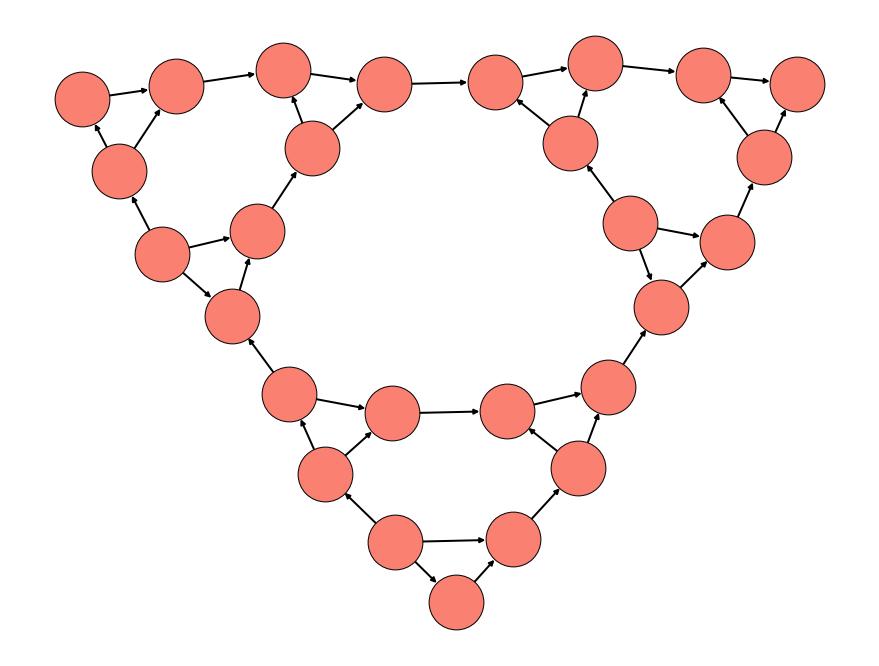

In [106]:
import matplotlib.pyplot as plt
from collections import Counter

nodes = ["1" ,"2" ,"3" ,"4" ,"5" ,"6" ,"7" ,"8" ,"9" ,"10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19" ,"20" ,"21" ,"22" ,"23" ,"24" ,"25" ,"26" ,"27"]
edges = [(1, 2),(1, 3),(1, 4),(2, 3),(3, 7),(4, 5),(4, 6),(5, 6),(6, 8),(7, 8),(7, 9),(8, 9),(10, 11),(10, 12),(10, 13),(11, 12), (12, 16), (13, 14), (13, 15), (14, 15),(15, 17),(16, 17),(16, 18),(17, 18),(19, 20),(19, 21),(19, 22),(20, 21),(21, 25),(22, 23),(22, 24),(23, 24),(24, 26),(25, 26),(25, 27),(26, 27),(9, 20),(5, 11),(18, 23)]

g      = nx.DiGraph((x, y, {'weight': 1}) for (x, y), v in Counter(edges).items())
layout = nx.nx_agraph.pygraphviz_layout(g)

fig, ax = plt.subplots(1, 1, figsize=(15.5, 12))
nx.draw(ax=ax, G=g, pos=layout, node_size=3000, node_color="salmon", edgecolors="k", width=2)

graph = g

In [42]:
def log2(prob):
    "Returns the log of prob in base 2"
    return log(prob, 2)

def entropy1(prob):
    """Half of the entropy function, as used in the InfoMap paper.
    entropy1(p) = p * log2(p)
    """
    if prob == 0:
        return 0
    return prob * log2(prob)


for node in graph:
    edges = graph.edges(node, data=True)
    total_weight = sum([data['weight'] for (_, _, data) in edges])
    for (_, _, data) in edges:
        data['weight'] = data['weight'] / total_weight
# Get its PageRank, alpha is 1-tau where [RAB2009 says \tau=0.15]
page_ranks = nx.pagerank(graph, alpha=1-TAU)
for (node, page_rank) in page_ranks.items():
    graph.nodes[node][PAGE_RANK] = page_rank


#modules = [Module(module_id, module, graph) for (module_id, module) in enumerate(single_nodes)]
def compute_module_properties(modules_list, network):
    modules = []
    graph   = network
    # loop through modules and compute stuff
    for (module_id, nodes) in enumerate(modules_list):

        module_id = module_id
        nodes     = frozenset(nodes)
        graph     = graph
        prop_nodes = 1 - float( len(nodes)) / len(graph)


        # Set the module_id for every node
        for node in nodes:
            graph.nodes[int(node)][MODULE_ID] = module_id



        total_pr = sum([graph.nodes[int(node)][PAGE_RANK] for node in nodes])

        # Exit probability of this module
        # .. Left half: tau * (n - n_i) / n * sum{alpha in i}(p_alpha)

        q_out = total_pr * TAU * prop_nodes

        # .. Right half: (1-tau) * sum{alpha in i}(sum{beta not in i}
        #                  p_alpha weight_alpha,beta)
        # This is what's in [RAB2009 eq. 6]. But it's apparently wrong if node alpha has no out-edges, which is not in the paper.

        for node in nodes:
            edges = graph.edges(node, data=True)
            page_rank = graph.nodes[int(node)][PAGE_RANK]
            if len(edges) == 0:
                q_out += page_rank * prop_nodes * (1 - TAU)
                continue

            for (_, dest, data) in edges:
                if dest not in nodes:
                    q_out += page_rank * data['weight'] * (1 - TAU)

        q_plus_p = q_out + total_pr
        module_dict = {}
        module_dict["prop_nodes"]  = prop_nodes
        module_dict["module_id"]   = module_id
        module_dict["total_pr"]    = total_pr
        module_dict["q_plus_p"]    = q_plus_p
        module_dict["nodes"]       = frozenset(nodes)
        module_dict["graph"]       = graph             # store graph with defined module id
        module_dict["q_out"]       = q_out

        # compute codebook length
        first  = -entropy1(q_out / q_plus_p)
        second = -sum( [entropy1(module_dict["graph"].nodes[int(node)][PAGE_RANK]/module_dict["q_plus_p"]) for node in module_dict["nodes"]])

        module_dict["codebook_length"] = q_plus_p * (first + second)
        modules.append(module_dict)

    return modules


def get_mdl(modules, total_pr_entropy):
    "Compute the MDL of this clustering according to [RAB2009, eq. 4]"
     # the map equation
    total_qout = 0
    total_qout_entropy = 0
    total_both_entropy = 0
    for mod in modules:
        q_out              = mod["q_out"]
        total_qout         += q_out
        total_qout_entropy += entropy1(q_out)
        total_both_entropy += entropy1(mod["q_plus_p"])

    term1 = entropy1(total_qout)
    term2 = -2 * total_qout_entropy
    term3 = -total_pr_entropy
    term4 = total_both_entropy
    return term1 + term2 + term3 + term4

def get_index_codelength(modules):
    "Compute the index codebook length according to [RAB2009, eq. 2]"
    if len(modules) == 1:
        return 0
    total_q = sum([mod["q_out"] for mod in modules])
    if total_q==0:
        return 0
    entropy = -sum([entropy1(mod["q_out"] / total_q) for mod in modules])
    return total_q * entropy

In [103]:
import numpy as np

# single_nodes is the "trivial"-initial module mapping
single_nodes     = [[nodes] for nodes in graph]

total_pr_entropy = sum([entropy1(graph.nodes[node][PAGE_RANK]) for node in graph])

######################## create modules dictionaries ########################
first_module    = single_nodes
modules_dicts   = compute_module_properties(first_module, graph)
map_eq          = get_mdl(modules_dicts, total_pr_entropy)
codebook_length = get_index_codelength(modules_dicts)

print(map_eq, codebook_length)


possible_new_merge = list(graph.edges())
map_eqs    = []
cb_lengths = []
for idx_merge in range(len(possible_new_merge)):
    new_merge          = [str(n) for n in list(possible_new_merge[idx_merge])]

    nodes_left_out     =  set(nodes)-set(new_merge)
    new_modules        = [[node] for node in nodes_left_out]
    new_modules.append(new_merge)

    modules_dicts   = compute_module_properties(new_modules, graph)

    map_eqs.append(get_mdl(modules_dicts, total_pr_entropy))
    cb_lengths.append(get_index_codelength(modules_dicts))

module_new = possible_new_merge[np.argmin(map_eqs)]

6.329992863927984 4.339256398680768


In [104]:
module_new

(26, 27)